In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
print("import success")

import success


In [2]:
admissions = pd.read_csv('../data/Raw/admissions.csv.gz', compression = 'gzip') 
diagnoses = pd.read_csv('../data/Raw/diagnoses_icd.csv.gz', compression='gzip')
d_icd = pd.read_csv('../data/Raw/d_icd_diagnoses.csv.gz', compression='gzip')
discharge = pd.read_csv('../data/Raw/discharge.csv.gz', compression='gzip')

print(f"Admissions: {admissions.shape}")
print(f"Diagnoses (ICD Code Assginments ): {diagnoses.shape}")
print(f"ICD Dictionary (Unique ICD codes): {d_icd.shape}")
print(f"Discharge Notes: {discharge.shape}")

Admissions: (546028, 16)
Diagnoses (ICD Code Assginments ): (6364488, 5)
ICD Dictionary (Unique ICD codes): (112107, 3)
Discharge Notes: (331793, 8)


Admissions: (546,028 rows, 16 columns) — 546,028 unique hospital visits across the dataset.

Diagnoses: (6,364,488 rows, 5 columns) — 6.3 million ICD code assignments. That's an average of about 11-12 diagnosis codes per admission which is realistic for ICU patients. Unique admissions does not translate to unique patients. 

ICD Dictionary: (112,107 rows, 3 columns) — 112,107 unique ICD codes in the lookup table. This shows you the scale of the classification problem.

Discharge Notes: (331,793 rows, 8 columns) — 331,793 discharge summaries. Note this is less than admissions (546k) because not every admission generates a discharge summary.



In [3]:
# Cell 3 — Inspect Columns
print("ADMISSIONS COLUMNS:", admissions.columns.tolist())
print()
print("DIAGNOSES COLUMNS:", diagnoses.columns.tolist())
print()
print("ICD DICTIONARY COLUMNS:", d_icd.columns.tolist())
print()
print("DISCHARGE COLUMNS:", discharge.columns.tolist())

ADMISSIONS COLUMNS: ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admit_provider_id', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'edregtime', 'edouttime', 'hospital_expire_flag']

DIAGNOSES COLUMNS: ['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version']

ICD DICTIONARY COLUMNS: ['icd_code', 'icd_version', 'long_title']

DISCHARGE COLUMNS: ['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq', 'charttime', 'storetime', 'text']


In [4]:
# Cell 3b — Check uniqueness
print("Unique admissions (hadm_id):", admissions['hadm_id'].nunique())
print("Unique patients (subject_id):", admissions['subject_id'].nunique())
print()
print("Avg admissions per patient:", 
      round(admissions['hadm_id'].nunique() / admissions['subject_id'].nunique(), 2))

Unique admissions (hadm_id): 546028
Unique patients (subject_id): 223452

Avg admissions per patient: 2.44


In [5]:
# Cell 4 — Preview Each Table
print("=== ADMISSIONS SAMPLE ===")
print(admissions[['subject_id', 'hadm_id', 'admittime', 
                   'dischtime', 'admission_type', 'race']].head(3))
print()
print("=== DIAGNOSES SAMPLE ===")
print(diagnoses.head(3))
print()
print("=== ICD DICTIONARY SAMPLE ===")
print(d_icd.head(3))
print()
print("=== DISCHARGE SAMPLE ===")
print(discharge[['subject_id', 'hadm_id', 
                  'note_type', 'text']].head(3))

=== ADMISSIONS SAMPLE ===
   subject_id   hadm_id            admittime            dischtime  \
0    10000032  22595853  2180-05-06 22:23:00  2180-05-07 17:15:00   
1    10000032  22841357  2180-06-26 18:27:00  2180-06-27 18:49:00   
2    10000032  25742920  2180-08-05 23:44:00  2180-08-07 17:50:00   

  admission_type   race  
0         URGENT  WHITE  
1       EW EMER.  WHITE  
2       EW EMER.  WHITE  

=== DIAGNOSES SAMPLE ===
   subject_id   hadm_id  seq_num icd_code  icd_version
0    10000032  22595853        1     5723            9
1    10000032  22595853        2    78959            9
2    10000032  22595853        3     5715            9

=== ICD DICTIONARY SAMPLE ===
  icd_code  icd_version                             long_title
0     0010            9         Cholera due to vibrio cholerae
1     0011            9  Cholera due to vibrio cholerae el tor
2     0019            9                   Cholera, unspecified

=== DISCHARGE SAMPLE ===
   subject_id   hadm_id note_type  \
0

Admissions dates show 2180 — remember from the CHANGELOG, MIMIC shifts all dates forward by a random offset per patient for de-identification. Actual admissions were 2008-2022 but appear as 2100s. This doesn't affect the project at all.

Diagnoses shows ICD version 9 for the first patient — this confirms our earlier discussion. This patient was admitted before 2015 so their codes are ICD-9. We'll filter these out and keep only version 10.

Discharge note_type shows "DS" — that stands for Discharge Summary. 

Discharge text shows \nName: ___ Unit No: _... — this is the de-identification at work. Patient names replaced with ___.  \n which are newline characters — this is the messy clinical text that needs to be clean.

In [6]:
# Cell 5 — Filter to ICD-10 only
print("ICD version distribution in diagnoses:")
print(diagnoses['icd_version'].value_counts())
print()

# Keep only ICD-10
diagnoses_10 = diagnoses[diagnoses['icd_version'] == 10]
print(f"ICD-9 rows: {len(diagnoses) - len(diagnoses_10):,}")
print(f"ICD-10 rows: {len(diagnoses_10):,}")
print(f"Unique admissions with ICD-10 codes: {diagnoses_10['hadm_id'].nunique():,}")

ICD version distribution in diagnoses:
icd_version
10    3455747
9     2908741
Name: count, dtype: int64

ICD-9 rows: 2,908,741
ICD-10 rows: 3,455,747
Unique admissions with ICD-10 codes: 254,377


In [12]:
code_counts = diagnoses_10['icd_code'].value_counts()

print(f"Total unique ICD-10 codes: {len(code_counts):,}")
print(f"\nTop 20 most frequent ICD-10 codes:")
print(code_counts.head(20))

Total unique ICD-10 codes: 19,440

Top 20 most frequent ICD-10 codes:
icd_code
E785      84570
I10       83775
Z87891    62806
K219      56157
F329      41876
I2510     41550
F419      38911
N179      35884
Z20822    33113
Z7901     30957
E039      28000
Z794      27642
E119      26266
F17210    24106
G4733     23933
E669      22004
D649      21137
I4891     21022
J45909    20679
Z7902     19961
Name: count, dtype: int64


Top 50 codes selected
Frequency range: 9,752 to 84,570


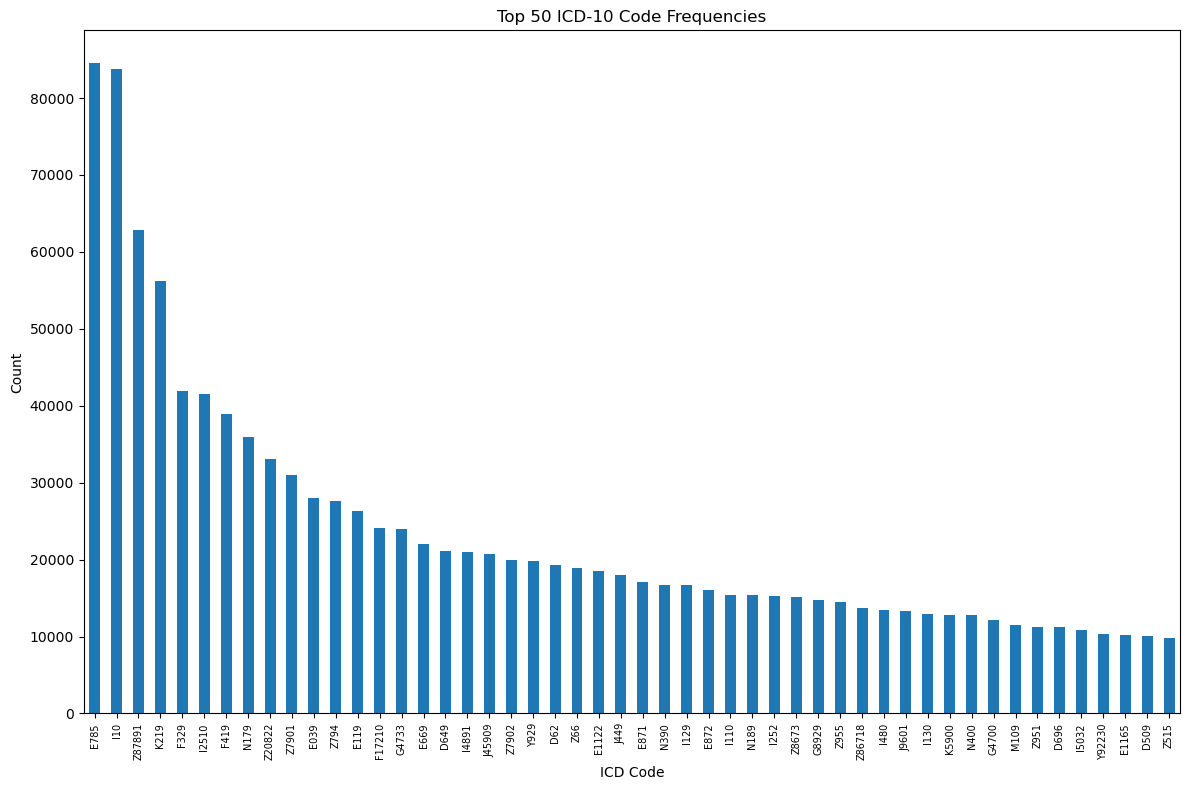

Plot saved to outputs/


In [ ]:
top50_codes = code_counts.head(50).index.tolist()
print(f"Top 50 codes selected")
print(f"Frequency range: {code_counts.iloc[49]:,} to {code_counts.iloc[0]:,}")

# Visualize
plt.figure(figsize=(12, 8))
code_counts.head(50).plot(kind='bar')
plt.title('Top 50 ICD-10 Code Frequencies')
plt.xlabel('ICD Code')
plt.ylabel('Count')
plt.xticks(rotation=90, fontsize=7)
plt.tight_layout()
plt.savefig('../outputs/top50_icd_distribution.png', dpi=150)
plt.show()
print("Plot saved to outputs/")

The long tail problem — a small number of codes appear thousands of times, while the vast majority appear rarely. 1st code appear 80K times but the 50th only appear like 5k times. 

In [15]:
# Cell 8 — Build Master Dataset

# Step 1: Filter diagnoses to top 50 codes only
diagnoses_top50 = diagnoses_10[diagnoses_10['icd_code'].isin(top50_codes)]
print(f"Diagnoses rows after top50 filter: {len(diagnoses_top50):,}")

# Step 2: Group ICD codes per admission into a list
icd_per_admission = diagnoses_top50.groupby('hadm_id')['icd_code'].apply(list).reset_index()
icd_per_admission.columns = ['hadm_id', 'icd_codes']
print(f"Unique admissions with top50 codes: {len(icd_per_admission):,}")

# Step 3: Merge with discharge notes
df = discharge.merge(icd_per_admission, on='hadm_id', how='inner')
print(f"After merging with discharge notes: {len(df):,}")

# Step 4: Merge with admissions to get subject_id properly
df = df.merge(admissions[['hadm_id', 'subject_id']], on='hadm_id', how='left')
print(f"Final dataset shape: {df.shape}")
print(f"\nSample row - ICD codes assigned:")
print(df)

Diagnoses rows after top50 filter: 1,172,228
Unique admissions with top50 codes: 231,580
After merging with discharge notes: 114,633
Final dataset shape: (114633, 10)

Sample row - ICD codes assigned:
               note_id  subject_id_x   hadm_id note_type  note_seq  \
0       10000084-DS-17      10000084  23052089        DS        17   
1       10000117-DS-21      10000117  22927623        DS        21   
2       10000117-DS-22      10000117  27988844        DS        22   
3       10000980-DS-24      10000980  25911675        DS        24   
4       10000980-DS-25      10000980  29659838        DS        25   
...                ...           ...       ...       ...       ...   
114628  19999784-DS-24      19999784  24755486        DS        24   
114629   19999784-DS-7      19999784  26194817        DS         7   
114630   19999784-DS-8      19999784  24935234        DS         8   
114631   19999828-DS-6      19999828  29734428        DS         6   
114632   19999828-DS-7      1

In [17]:
# Cell 9 — Clean and Keep Only Necessary Columns
df_clean = df[['hadm_id', 'subject_id_x', 'text', 'icd_codes']].copy()
df_clean.columns = ['hadm_id', 'subject_id', 'text', 'icd_codes']

# Check for nulls
print("Null values:")
print(df_clean.isnull().sum())
print(f"\nFinal clean dataset: {df_clean.shape}")
print(f"Unique patients: {df_clean['subject_id'].nunique():,}")
print(f"Unique admissions: {df_clean['hadm_id'].nunique():,}")
print(df_clean)

Null values:
hadm_id       0
subject_id    0
text          0
icd_codes     0
dtype: int64

Final clean dataset: (114633, 4)
Unique patients: 60,860
Unique admissions: 114,633
         hadm_id  subject_id  \
0       23052089    10000084   
1       22927623    10000117   
2       27988844    10000117   
3       25911675    10000980   
4       29659838    10000980   
...          ...         ...   
114628  24755486    19999784   
114629  26194817    19999784   
114630  24935234    19999784   
114631  29734428    19999828   
114632  25744818    19999828   

                                                     text  \
0        \nName:  ___                    Unit No:   __...   
1        \nName:  ___                 Unit No:   ___\n...   
2        \nName:  ___                 Unit No:   ___\n...   
3        \nName:  ___          Unit No:   ___\n \nAdmi...   
4        \nName:  ___          Unit No:   ___\n \nAdmi...   
...                                                   ...   
114628   \nNa

Went from 546,028 total admissions down to 114,633 — that reduction happened because we filtered to only admissions that had at least one top-50 ICD-10 code AND had a discharge summary.

In [18]:
import re

# Cell 10 — Text Cleaning
def clean_clinical_text(text):
    # Remove de-identification artifacts
    text = re.sub(r'\[\*\*.*?\*\*\]', '', text)
    # Remove excessive whitespace and newlines
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Lowercase
    text = text.lower().strip()
    return text

df_clean['text_clean'] = df_clean['text'].apply(clean_clinical_text)

# Verify
print("Original text sample:")
print(df_clean['text'].iloc[0][:300])
print("\nCleaned text sample:")
print(df_clean['text_clean'].iloc[0][:300])

Original text sample:
 
Name:  ___                    Unit No:   ___
 
Admission Date:  ___              Discharge Date:   ___
 
Date of Birth:  ___             Sex:   M
 
Service: MEDICINE
 
Allergies: 
No Known Allergies / Adverse Drug Reactions
 
Attending: ___.
 
Chief Complaint:
Visual hallucinations
 
Major Surgica

Cleaned text sample:
name: ___ unit no: ___ admission date: ___ discharge date: ___ date of birth: ___ sex: m service: medicine allergies: no known allergies / adverse drug reactions attending: ___. chief complaint: visual hallucinations major surgical or invasive procedure: n/a history of present illness: ___ male with


In [19]:
from sklearn.preprocessing import MultiLabelBinarizer

# Cell 11 — Build Multi-Label Matrix
mlb = MultiLabelBinarizer(classes=top50_codes)
y = mlb.fit_transform(df_clean['icd_codes'])

print(f"Label matrix shape: {y.shape}")
print(f"Meaning: {y.shape[0]} admissions x {y.shape[1]} ICD codes")
print(f"\nAvg codes per admission: {y.sum(axis=1).mean():.2f}")
print(f"Max codes per admission: {y.sum(axis=1).max()}")
print(f"Min codes per admission: {y.sum(axis=1).min()}")

Label matrix shape: (114633, 50)
Meaning: 114633 admissions x 50 ICD codes

Avg codes per admission: 5.31
Max codes per admission: 23
Min codes per admission: 1


we are trying to binary encode the data. 

for example if Row 0 had I10, E785, K219 so those columns are 1 and everything else is 0. 
Row 1 had F329 and N179 so those are 1. And so on.

In [20]:
from sklearn.model_selection import train_test_split

# Cell 12 — Patient-Level Train/Test Split
unique_patients = df_clean['subject_id'].unique()

train_patients, test_patients = train_test_split(
    unique_patients, 
    test_size=0.2, 
    random_state=42
)

train_patients, val_patients = train_test_split(
    train_patients, 
    test_size=0.1, 
    random_state=42
)

# Split dataframe based on patient assignment
train_df = df_clean[df_clean['subject_id'].isin(train_patients)].reset_index(drop=True)
val_df = df_clean[df_clean['subject_id'].isin(val_patients)].reset_index(drop=True)
test_df = df_clean[df_clean['subject_id'].isin(test_patients)].reset_index(drop=True)

print(f"Train admissions: {len(train_df):,} ({len(train_df)/len(df_clean)*100:.1f}%)")
print(f"Val admissions:   {len(val_df):,} ({len(val_df)/len(df_clean)*100:.1f}%)")
print(f"Test admissions:  {len(test_df):,} ({len(test_df)/len(df_clean)*100:.1f}%)")
print(f"\nTotal: {len(train_df) + len(val_df) + len(test_df):,}")
print(f"\nPatient overlap check:")
print(f"Train/Test overlap: {len(set(train_patients) & set(test_patients))}")
print(f"Train/Val overlap: {len(set(train_patients) & set(val_patients))}")

Train admissions: 82,501 (72.0%)
Val admissions:   9,084 (7.9%)
Test admissions:  23,048 (20.1%)

Total: 114,633

Patient overlap check:
Train/Test overlap: 0
Train/Val overlap: 0


We are making sure that - 

subject_id 10000117 → TRAIN only
    all their admissions → TRAIN

subject_id 10000980 → TEST only  
    all their admissions → TEST

subject_id 10000084 → VAL only
    all their admissions → VAL

What we are preventing:
subject_id 10000117 → admission 1 in TRAIN
                    → admission 2 in TEST  ← NOT ALLOWED    

Was aware of the tradeoff between data efficiency and leakage prevention and chose evaluation integrity over marginal data gain.

In [21]:
import pickle

# Cell 13 — Save Processed Data
train_df.to_csv('../data/Processed/train.csv', index=False)
val_df.to_csv('../data/Processed/val.csv', index=False)
test_df.to_csv('../data/Processed/test.csv', index=False)

# Save the label binarizer and top50 codes for later use
with open('../data/Processed/mlb.pkl', 'wb') as f:
    pickle.dump(mlb, f)

with open('../data/Processed/top50_codes.pkl', 'wb') as f:
    pickle.dump(top50_codes, f)

print("Saved:")
print("  train.csv")
print("  val.csv")
print("  test.csv")
print("  mlb.pkl")
print("  top50_codes.pkl")

Saved:
  train.csv
  val.csv
  test.csv
  mlb.pkl
  top50_codes.pkl
